### Forecast de demanda: Facturapp

#### ✅ XGBoost

##### Datos

In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [2]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [4]:
# Lista de códigos de producto que quieres filtrar
codigos_producto = ['60']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_xgboost = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

df_xgboost = df_xgboost[['fecha_venta', 'cantidad_ventas_producto']]

# Renombramos variables para que prophet tome como input
df_xgboost = df_xgboost.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df_xgboost.head()

,ds,y
0,2022-04-18,1.0
1,2022-04-20,5.0
2,2022-04-21,2.0
3,2022-04-22,7.0
4,2022-04-23,6.0


Para modelar vacaciones y eventos especiales con selección manual

In [ ]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [ ]:
# Para ver qué días festivos se incluyen
# m.train_holiday_names

In [5]:
from prophet import Prophet

m = Prophet()
# m = Prophet(holidays=holidays) #con ese parámetro agregamos todas las fechas que seteamos previamente
# m.add_country_holidays(country_name='UY')

m.fit(df_prophet)

c:\Users\Juancito\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
future = m.make_future_dataframe(periods=20)
future.tail()

,ds
239,2024-06-10
240,2024-06-11
241,2024-06-12
242,2024-06-13
243,2024-06-14


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
239,2024-06-10,1.345617,-2.328080,5.113144
240,2024-06-11,2.112047,-1.570689,5.864578
241,2024-06-12,3.452236,-0.442579,7.183436
242,2024-06-13,2.964807,-0.308600,6.602903
243,2024-06-14,5.043626,1.293986,8.805505


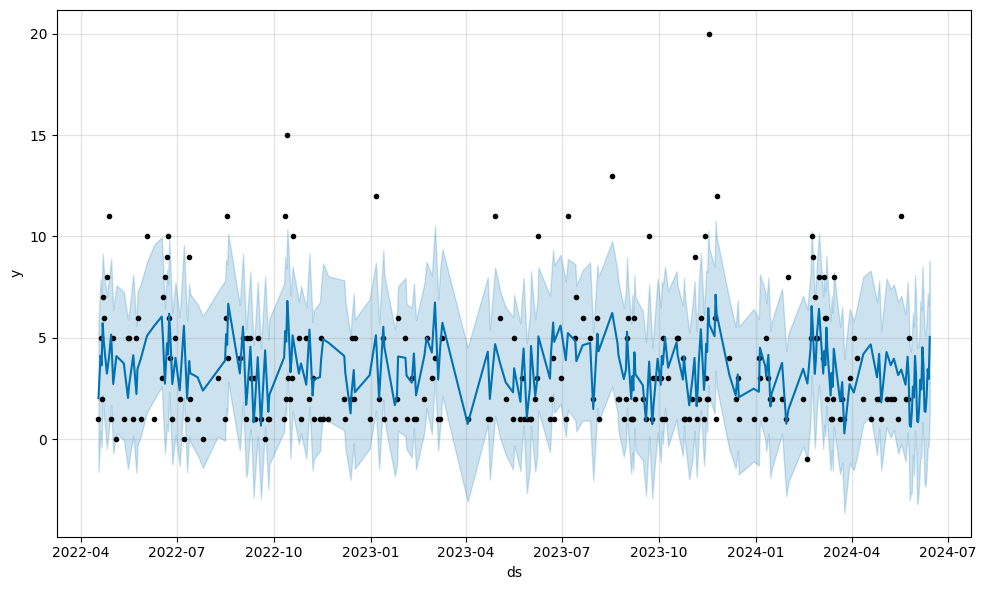

In [8]:
fig1 = m.plot(forecast)

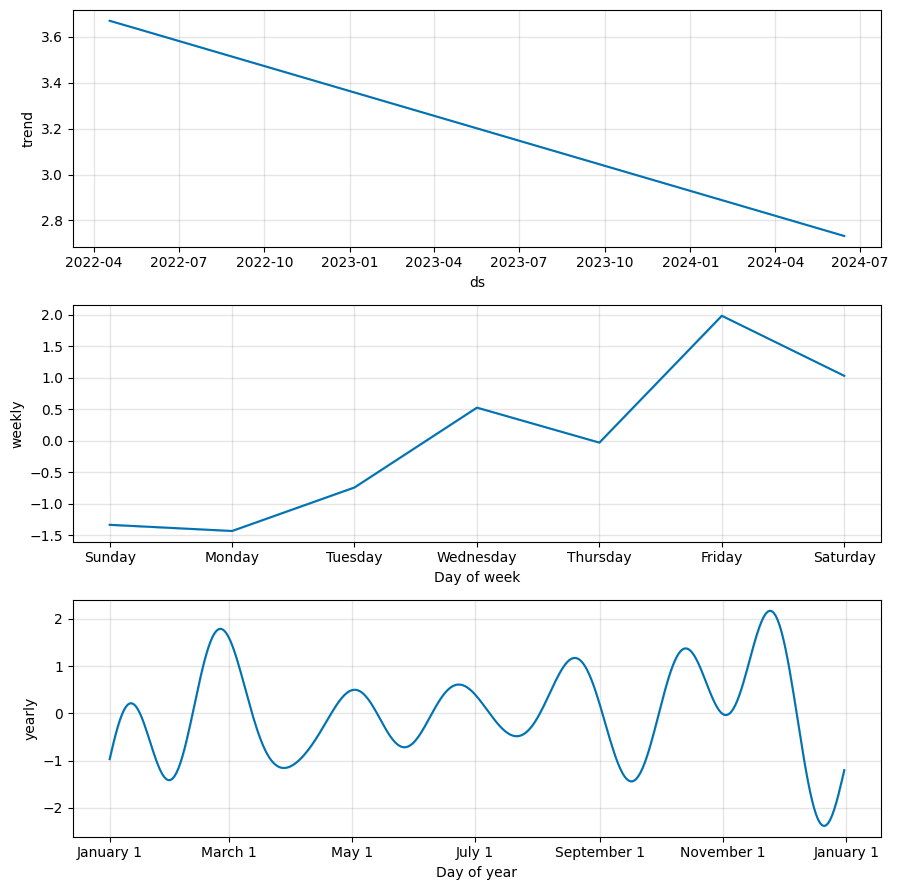

In [9]:
fig2 = m.plot_components(forecast)

In [10]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [11]:
plot_components_plotly(m, forecast)

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('prophet_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [ ]:
m = Prophet(growth='flat')